In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse as sp
import pickle


In [3]:
# Load ANNData
adata_xeno = sc.read_h5ad("../adata_xeno_with_symbols.h5ad")
adata_xeno


AnnData object with n_obs × n_vars = 33985 × 41560
    obs: 'barcode_base', 'CellBarcode', 'Stages', 'CellType', 'Phenograph', 'Pseudotime_Pltr', 'Differentiation Potential_Pltr', 'Per Stage Louvain', 'CytoTRACE', 'CV', 'CCphase', 'Branch Probabilities Basal', 'Branch Probabilities Goblet', 'Branch Probabilities Ionocytes', 'Branch Probabilities Multiciliated', 'stage_from_file', 'sample'
    var: 'raw_name', 'xeno_symbol'

In [4]:
with open("../data/xeno_to_human_baseline.pkl", "rb") as f:
    xeno_to_human_baseline = pickle.load(f)

len(xeno_to_human_baseline)
list(xeno_to_human_baseline.items())[:5]


[('csnk1a1', 'casein kinase 1 alpha 1'),
 ('fgfr3', 'fibroblast growth factor receptor 3 (achondroplasia'),
 ('hspa5', 'heat shock protein family A (Hsp70) member 5'),
 ('nr2f2', 'nuclear receptor subfamily 2 group F member 2'),
 ('nr4a1', 'nuclear receptor subfamily 4 group A member 1')]

In [5]:
# Xenopus symbols for which we have a human mapping
mapped_xeno_symbols = set(xeno_to_human_baseline.keys())

# Restrict to genes present in adata_xeno
mask = adata_xeno.var["xeno_symbol"].isin(mapped_xeno_symbols)
adata_map = adata_xeno[:, mask].copy()

adata_map.n_vars


101

In [6]:
# Creating a series: Xenopus symbols -> human symbols for these genes
xeno_symbols = adata_map.var["xeno_symbol"].values
human_symbols = [xeno_to_human_baseline[s] for s in xeno_symbols]

map_df = pd.DataFrame({
    "xeno_symbol": xeno_symbols,
    "human_symbol": human_symbols
})
map_df.head()


,xeno_symbol,human_symbol
0,paics,phosphoribosylaminoimidazole carboxylase and p...
1,adh4,alcohol dehydrogenase 4 (class II)
2,dda1,DET1 and DDB1 associated 1
3,psip1,PC4 and SFRS1 interacting protein 1
4,mtmr3,myotubularin related protein 3


In [7]:
# Building a Human gene count matrix
X = adata_map.X
if not sp.issparse(X):
    X = sp.csr_matrix(X)

# Unique human genes and index
unique_human_genes = np.unique(map_df["human_symbol"])
human_index = {g: i for i, g in enumerate(unique_human_genes)}

n_cells = adata_map.n_obs
n_human = len(unique_human_genes)

X_human = sp.lil_matrix((n_cells, n_human), dtype=X.dtype)

# Aggregate counts for all Xenopus genes mapping to the same human gene
for j, (x_sym, h_sym) in enumerate(zip(map_df["xeno_symbol"], map_df["human_symbol"])):
    col_idx = human_index[h_sym]
    X_human[:, col_idx] += X[:, j]

X_human = X_human.tocsr()


In [8]:
# Create a human-mapped ANNData object
from anndata import AnnData

adata_human = AnnData(X=X_human)

# Copy cell metadata and embeddings from adata_xeno
adata_human.obs = adata_xeno.obs.copy()
if "X_umap" in adata_xeno.obsm:
    adata_human.obsm["X_umap"] = adata_xeno.obsm["X_umap"].copy()

# Set human gene names
adata_human.var = pd.DataFrame(index=unique_human_genes)
adata_human.var.index.name = "human_symbol"

adata_human


AnnData object with n_obs × n_vars = 33985 × 101
    obs: 'barcode_base', 'CellBarcode', 'Stages', 'CellType', 'Phenograph', 'Pseudotime_Pltr', 'Differentiation Potential_Pltr', 'Per Stage Louvain', 'CytoTRACE', 'CV', 'CCphase', 'Branch Probabilities Basal', 'Branch Probabilities Goblet', 'Branch Probabilities Ionocytes', 'Branch Probabilities Multiciliated', 'stage_from_file', 'sample'

In [9]:
# Basic normalization
sc.pp.normalize_total(adata_human, target_sum=1e4)
sc.pp.log1p(adata_human)

# Save to disk
adata_human.write("../data/adata_human_mapped_101genes.h5ad")


/opt/miniconda3/envs/xenopus_sc/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


/opt/miniconda3/envs/xenopus_sc/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/opt/miniconda3/envs/xenopus_sc/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:840: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


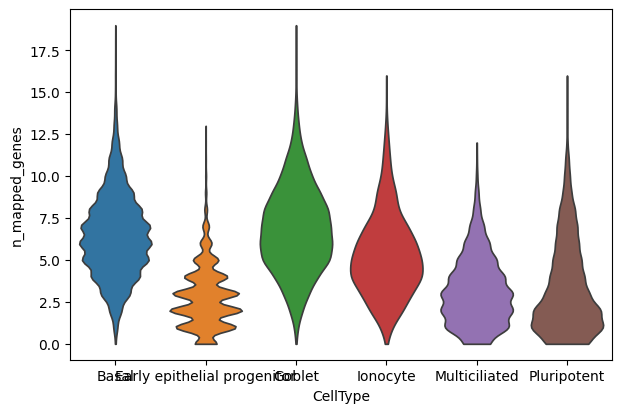

In [10]:
# Calculate the number of non-zero mapped genes per cell
n_nonzero = (adata_human.X > 0).sum(axis=1)
if hasattr(n_nonzero, "A1"):   # if sparse matrix
    n_nonzero = n_nonzero.A1

adata_human.obs["n_mapped_genes"] = n_nonzero

sc.pl.violin(
    adata_human,
    keys="n_mapped_genes",
    groupby="CellType",
    stripplot=False
)


In [ ]:
import scanpy as sc

# Compute neighbors and UMAP from the 101 human genes
sc.pp.pca(adata_human)
sc.pp.neighbors(adata_human, n_neighbors=15, n_pcs=20)
sc.tl.umap(adata_human)

sc.pl.umap(adata_human, color="CellType", s=5)


/opt/miniconda3/envs/xenopus_sc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
